# 0.0 IMPORTS

In [1]:
import pandas               as pd
import inflection 
import math
import numpy               as np
import seaborn             as sns
import datetime            as dt
import matplotlib.gridspec as gridspec


       
from scipy                  import stats  as ss
from matplotlib             import pyplot as plt
from matplotlib             import gridspec
from IPython.display        import Image
from sklearn.preprocessing  import RobustScaler,MinMaxScaler





C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.01 Helper Funcionts

In [ ]:
def cramer_v (x,y):
#Confusion Metrics (Matriz de Confusao): Faz uma contagem de linhas conforme a combinacao de valores de  variáveis
    cm = pd.crosstab(x ,y).values
    n = cm.sum()
    r,k = cm.shape
    #formula do chi2
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)


    return np.sqrt ((chi2corr/n) / (min(kcorr-1,rcorr-1)))

#Formula de V Cromer sendo
#k: Numero de colunas
#r: Numero de linhas
#n: numero de elementos


## 0.02 Loading Data

In [2]:
df_sales_raw = pd.read_csv ('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory=False)
#Merge
df_raw = pd.merge (df_sales_raw,df_store_raw, how='left', on = 'Store')


# 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [3]:
#Cópia dos dados da secao anterior - backup caso precise rodar novamente
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',                           'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2',             'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new
                

##  1.2. Date Dimension


In [6]:
print ('Number of rows {}'.    format (df1.shape[0]))
print ('Number of columns {}'. format (df1.shape[1]))



Number of rows 1017209
Number of columns 18


## 1.3 Data Types

In [7]:
#Tranformando o campo data em tipo data
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
#competition_distance             
df1['competition_distance'] =df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year  if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )

#promo2_since_week        
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval            
month_map = {1  : 'Jan',2  : 'Feb',3  : 'Mar',4  : 'Apr',5  : 'May',6  : 'Jun',7  : 'Jul',8  : 'Aug',9  : 'Sep',10 : 'Oct',11 : 'Nov',12 : 'Dec' }

df1['promo_interval'].fillna(0,inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)


#comparando se o mes de venda 'date'está contido no periodo de promocao 'promo_intervale separando os meses da coluna promo_interval com espaco pois estao todos juntos'
df1['is_promo'] =df1[['promo_interval', 'month_map']].apply                                                                            (lambda x: 0 if x['promo_interval'] == 0 else                                                                                             1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1)



In [10]:
df1.sample(5).T

,989700,503450,388508,39271,233695
store,366,256,791,247,661
day_of_week,5,7,2,5,6
date,2013-01-25 00:00:00,2014-04-06 00:00:00,2014-07-22 00:00:00,2015-06-26 00:00:00,2015-01-03 00:00:00
sales,6208,0,6273,6797,6330
customers,617,0,741,553,524
open,1,0,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,1
store_type,d,a,a,d,d


## 1.6 Change Types


In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week']= df1['promo2_since_week'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')


In [12]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
684791,967,6,2013-10-26,5082,576,1,0,0,0,a,c,3560.0,9,2013,1,36,2013.0,"Jan,Apr,Jul,Oct",Oct,1
451777,988,5,2014-05-23,4547,688,1,1,0,0,a,a,30.0,11,2012,0,21,2014.0,0,May,0
185104,15,7,2015-02-15,0,0,0,0,0,0,d,c,4110.0,3,2010,1,14,2011.0,"Jan,Apr,Jul,Oct",Feb,0
657599,535,2,2013-11-19,9453,1043,1,1,0,0,a,a,3570.0,4,2007,0,47,2013.0,0,Nov,0
768068,619,1,2013-08-12,6842,607,1,1,0,1,a,a,1600.0,6,2006,1,45,2009.0,"Feb,May,Aug,Nov",Aug,1


## 1.7 Descriptive Statiscal


In [13]:
#Separando os atributos numericos
num_atributes = df1.select_dtypes(include =['int64', 'float64'])

#Separando os atributos categóricos
cat_atributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])


### 1.7.1 Numerical Atributes

In [14]:
#Central Tendency - mean , median
ct1= pd.DataFrame(num_atributes.apply(np.mean)).T
ct2= pd.DataFrame(num_atributes.apply(np.median)).T

#Dispersao : std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_atributes.apply(np.std)).T
d2 = pd.DataFrame(num_atributes.apply(min)).T
d3 = pd.DataFrame(num_atributes.apply(max)).T
d4 = pd.DataFrame(num_atributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_atributes.apply (lambda x: x.skew())).T
d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T


#Concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['atributes','min','max','range','mean','meadian','std','skew','kurtoses']
m

,atributes,min,max,range,mean,meadian,std,skew,kurtoses
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2  Gráficos de Dispersão


C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


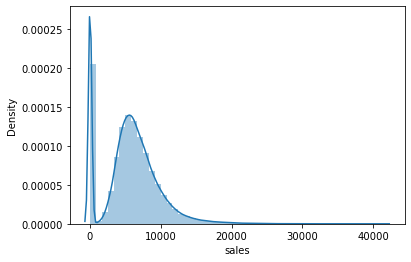

In [15]:
sns.distplot(df1['sales']);



C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


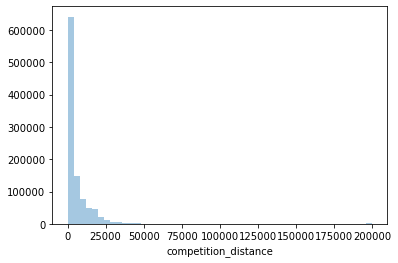

In [16]:
sns.distplot(df1['competition_distance'], kde=False);





In [17]:
### 1.7.1 Categorical Atributes
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

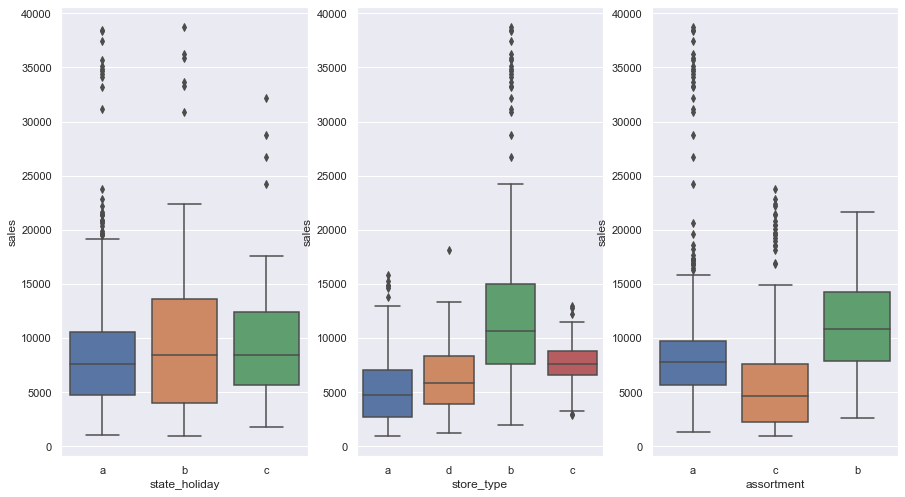

In [18]:
sns.set(rc={'figure.figsize':(15,8.27)})


aux = df1[(df1['state_holiday']!= '0') & (df1['sales']>0)]

plt.subplot (1,3,1)
sns.boxplot(data=aux, x ='state_holiday',y ='sales' )

plt.subplot(1,3,2)

sns.boxplot(data=aux, x= 'store_type', y = 'sales')

plt.subplot(1,3,3)
sns.boxplot(data=aux, x='assortment', y = 'sales' )



# 2.0 PASSO 02 - FEATURE ENGINEERING

In [19]:
df2 = df1

## 2.1. Mapa Mental de Hipóteses


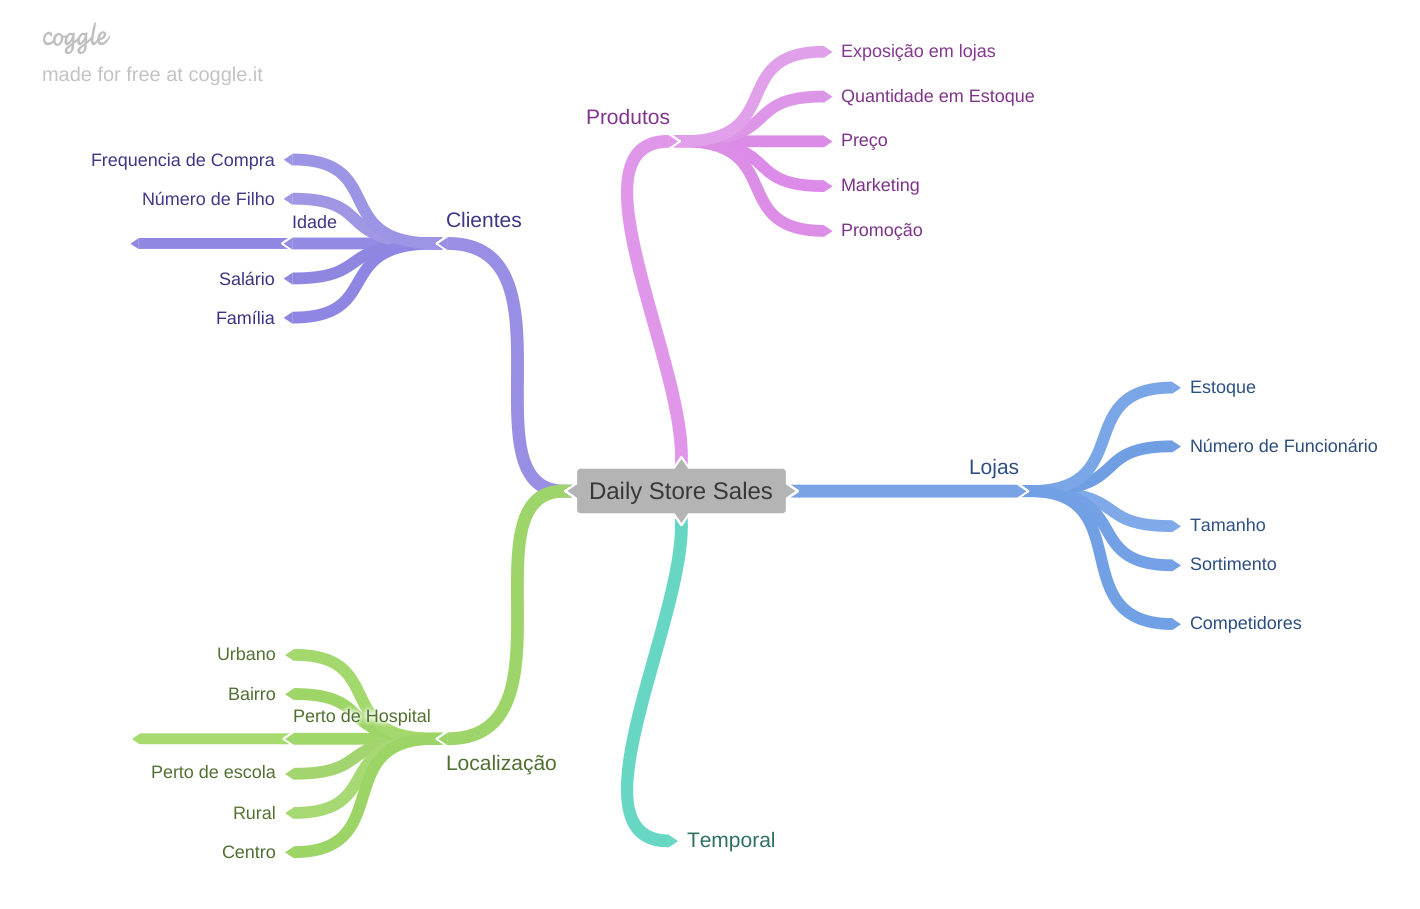

In [20]:
Image('img\MindMapHypothesis.png')

## 2. 2 Lista de Hipóteses:

### 2.2.1. Hipoteses Loja
**1.**  Lojas com número maior de funcionários deveriam vender mais.

**2.**  Lojas com maior capacidade de estoque deveriam vender mais.

**3.**  Lojas com maior porte deveriam vender mais.

**4.**  Lojas com maior sortimentos deveriam vender mais.

**5.**  Lojas com competidores mais próximos deveriam vender menos.

**6.**  Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto
**1.**  Lojas que investem mais em Marketing deveriam vender mais.

**2.**  Lojas com maior exposição de produto deveriam vender mais.

**3.**  Lojas com produtos com preço menor deveriam vender mais.

**5.**  Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.**  Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.**  Lojas com mais dias de promoção deveriam vender mais.

**8.**  Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo
**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista  Hipóteses Finais


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day']= df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competion since
df2['competition_since']=df2.apply(lambda x: dt.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis=1)


df2['competition_time_month']=((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

#promo since
##convertendo o ano de float para inteiro
df2['promo2_since_year'] = df2['promo2_since_year'].astype('int64')

##juntando o ano com o mes
df2['promo_since'] = df2['promo2_since_year'].astype(str) +  '-' + df2['promo2_since_week'].astype(str)

##convertendo a data em semana
df2['promo_since'] = df2['promo_since'].apply (lambda x: dt.datetime.strptime (x+ '-1', '%Y-%W-%w') - dt.timedelta(days=7))

##subraindo a data de promocao da data de venda para achar quantas semanas ficou em promocao
df2['promo_time_week']= ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


#assortment
##atribuindo o significado de cada letra no dataframe
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x== 'b' else 'extend')


#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'Christmas' if x == 'c' else 'regular_day')


C:\Users\Jacqueline\AppData\Local\Temp\ipykernel_16152\3472077806.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [22]:
df2.sample(3).T




,625987,456473,321969
store,143,109,601
day_of_week,2,7,3
date,2013-12-17 00:00:00,2014-05-18 00:00:00,2014-10-01 00:00:00
sales,11530,0,4062
customers,891,0,362
open,1,0,1
promo,1,0,1
state_holiday,regular_day,regular_day,regular_day
school_holiday,0,0,0
store_type,d,a,d


In [23]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [25]:
#Filtrando as linhas de lojas fechdas pois nao faz sentindo fazer uma previsao de venda de loja fechada e tbm de vendas diferentes de zero

#Filtragem de linhas a serem utilizadas
df3 = df3[(df3['open'] !=0 ) & (df3['sales'] > 0)]


## 3.2 Seleção  das colunas

In [26]:
#Excluindo as colunas de clientes pois no momento do modelo em producao nao se tem essa variavel e nao faz sentido colocar a variavel de loja aberta uma vez que ela nao terá um resutado diferente. As colunas de promo_interval e month_map sao excluídas pq foram usadas para derivar colunas

#seleca de colunas a serem excluídas
cols_drop = ['customers', 'open','promo_interval', 'month_map']

#dropando as colunas

df3 = df3.drop(cols_drop, axis = 1)




In [27]:
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [28]:
df4 = df3.copy()

### 4.1.1  Response Variable


C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

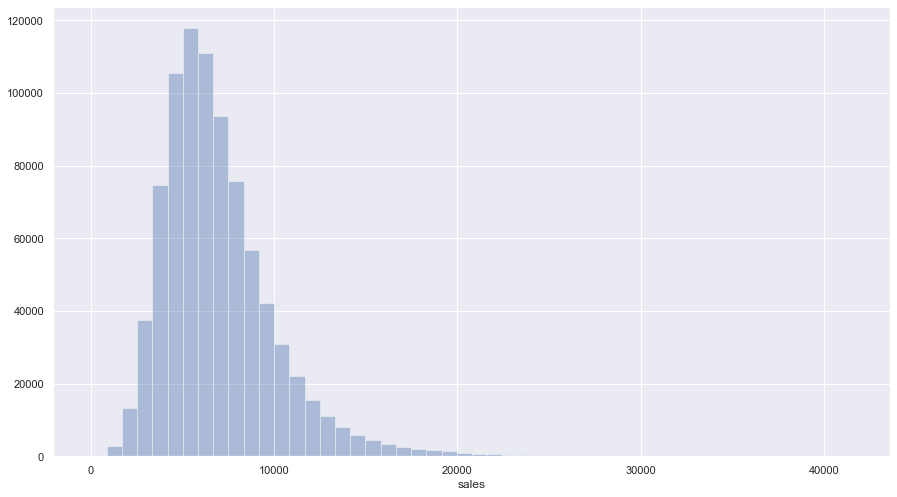

In [29]:
sns.distplot(df4['sales'],kde = False)



### 4.1.2  Numerical Variable

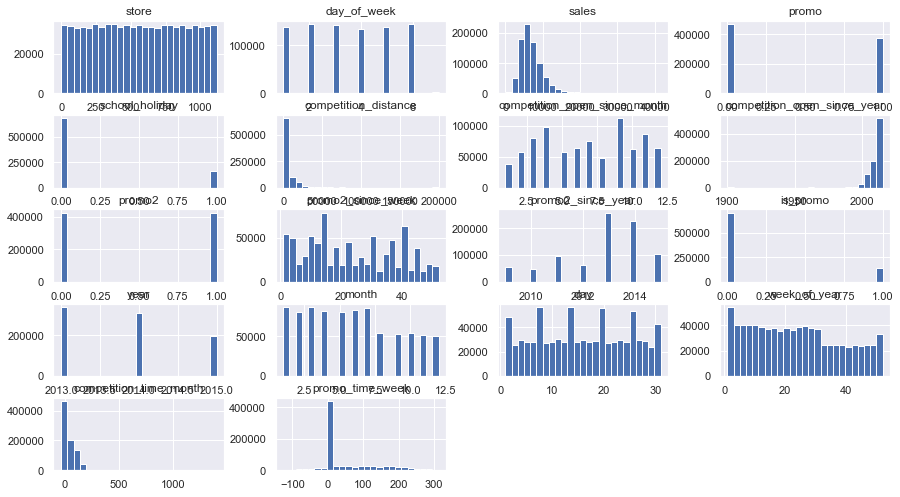

In [30]:
#Separando os atributos numericos
num_attributes = df4.select_dtypes(include =['int64', 'float64'])

num_attributes.hist(bins = 25);


*store* : é o id da loja, logo na frequencia aperece tudo igual

*day of week:* é uma coluna que identifica quando a venda foi feita. Observa-se que as vendas tem pouca variacao de segunda a sabado. Somente no domingo as vendas  caem dastricamente;

*Sales* As vendas se concentram numa faixa de até 20000 . 

*Promo* as vendas nao aumentaram qdo estavam em promoção

*school holidday* Feriados escolares nao aumentam as vendas

*Competion Distance* : os competitodores nao estao há uma longa distancia das lojas da rossmann

*Competion Open Since month* as vendas caem nos primeiros 3 meses após a abertura da loja, sendo que no quarto mes as vendas aumentam, 

*Competition open since year*: os conccorrentes foram abertos nos últimos anos;

*year* As vendas vem caindo ano a ano

*month* O primeiro semestre é o período de maior faturamento

*day* as maiores vendas ocorrem nos dias 10,20 e 30 de cada mes

*week of yea* o maior pico de venda ocorre na primeira semana do ano



### 4.1.2  Categorical Variable



In [31]:
df4['assortment'].drop_duplicates()




0       basic
3      extend
258     extra
Name: assortment, dtype: object

C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

<AxesSubplot:xlabel='sales', ylabel='Density'>

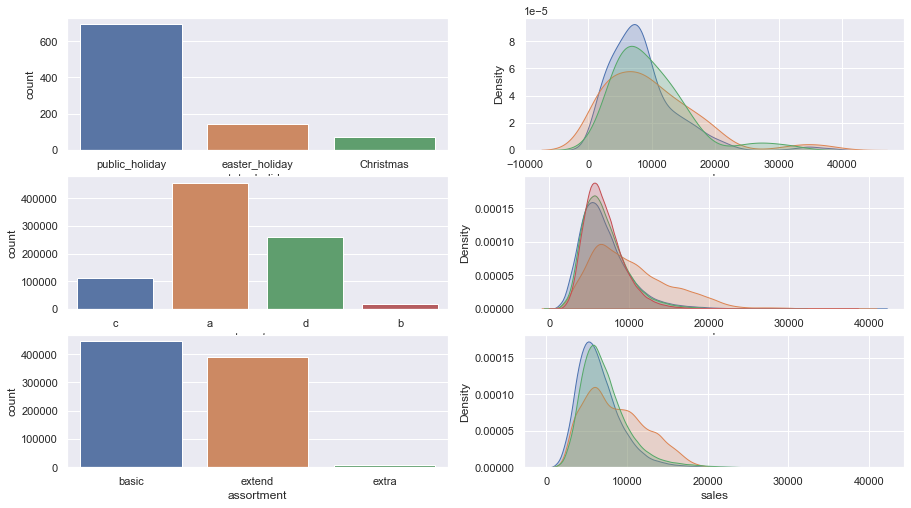

In [32]:
# state_holiday

plt.subplot(3,2,1) 
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot  (df4[df4['state_holiday'] == 'public_holiday']['sales'], label ='public_holiday', shade = True)
sns.kdeplot  (df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'ester_holiday', shade = True)
sns.kdeplot  (df4[df4['state_holiday'] == 'Christmas']['sales'], label = 'christmas', shade = True)


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot  (df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot  (df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot  (df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot  (df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])


plt.subplot(3,2,6)
sns.kdeplot  (df4[df4['assortment'] == 'basic'] ['sales'], label = 'basic', shade = True)
sns.kdeplot  (df4[df4['assortment'] == 'extra'] ['sales'], label = 'extra', shade = True)
sns.kdeplot  (df4[df4['assortment'] == 'extend']['sales'], label = 'extend', shade = True)





## 4.1 Analise Univariada

## 4.2 Analise Bivariada

### H1.  Lojas com maior sortimentos deveriam vender mais.
***Falsa *** Lojas com MAIOR SORTIMENTO  vendem MENOS. 

<AxesSubplot:xlabel='year_week'>

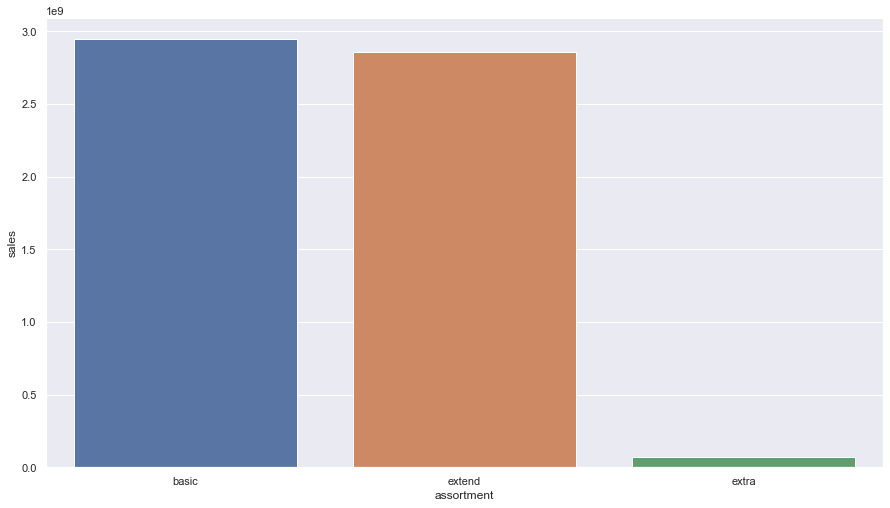

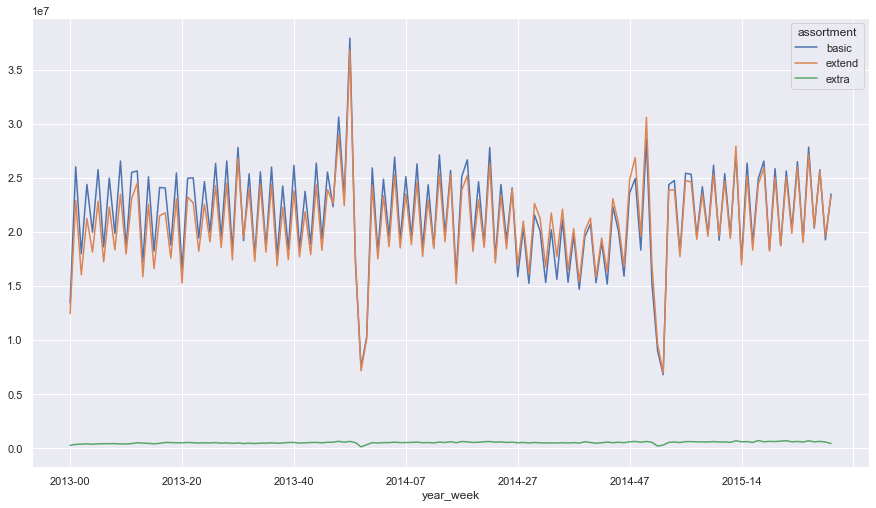

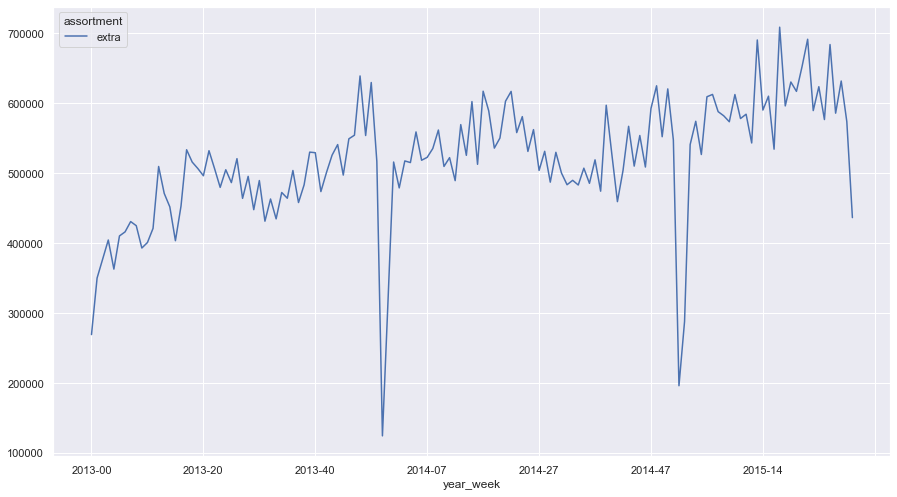

In [33]:
#plotando um gráfico de barra observa-se que o maior sortimento (extra) não vende mais que os demais.
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot (data=aux1, x= 'assortment', y = 'sales');

#Verificando se ao longo do tempo houve uma mudança de comportamento
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

#pivotando as colunas para que as semanas do ano sejam únicas e colocando a assortment como coluna
aux2.pivot (index='year_week', columns= 'assortment',values='sales').plot()

##Nao houve uma alteracao ao longo dos anos, mas como os valores sao bem diferentes de vendas do extra para os demais, vale a pena gerar um gráfico só do extra para entender o seu comportamento ao longo dos anos. Para isso será filtrada somente o assortment extra

aux3 = aux2[aux2['assortment']=='extra']

aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot()











### H2.  Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

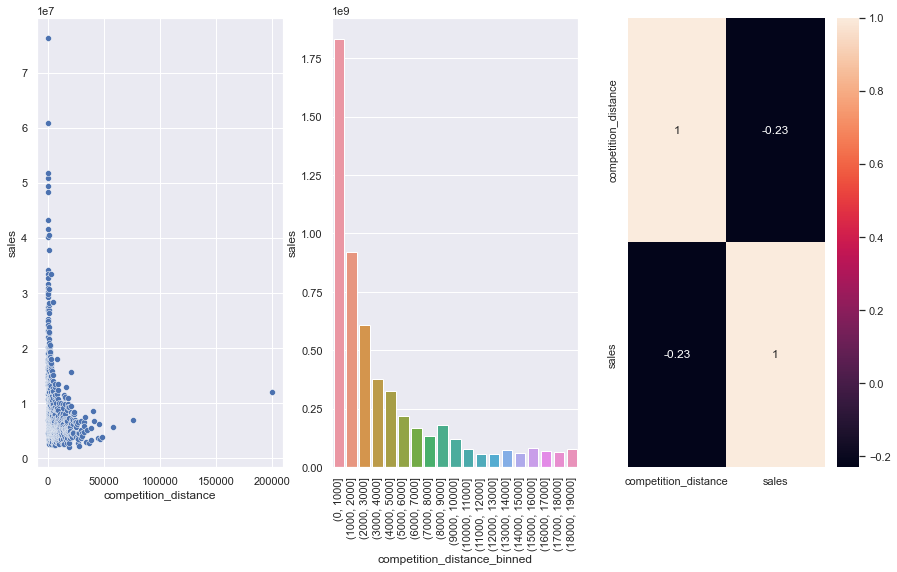

In [34]:
#Agrupando as vendas por distancia de competidores
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#gerando gráfico para ver concentração de dados
plt.subplot (1,3,1)
sns.scatterplot (data = aux1, x= 'competition_distance', y= 'sales');

## Nao é indicado gerar gráfico de barras com valores muito granulares, entao o ideal é gerar categorias
#sns.barplot (data= aux1, x='competition_distance' , y='sales');

#montando a forma dde agruoamento
bins = list(np.arange (0,20000,1000))

#indicando a coluna para que seja agrupado
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'],bins=bins)

#somando os valores agora com dados agrupados por distancias
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot (1,3,2)
sns.barplot (data = aux2, x='competition_distance_binned', y = 'sales');
plt.xticks(rotation = 90);

#Verificando a força da correlação entre as variáveis venda e distancia

plt.subplot(1,3,3)

x= sns.heatmap(aux1.corr(method='pearson'), annot = True);






### H3.  Lojas com competidores à mais tempo deveria vender mais
**Falsa** Lojas com COMPETIDORES HA MAIS TEMPO vendem MENOS

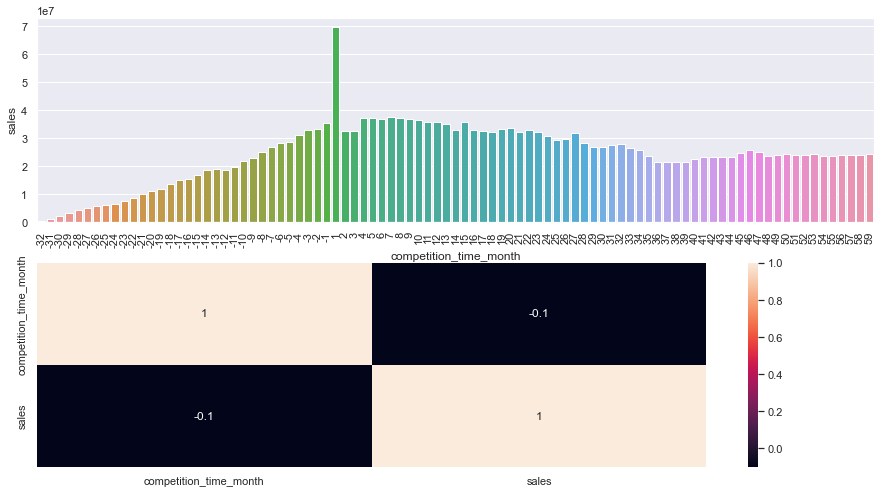

In [35]:
plt.subplot (2,1,1)

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60)  &  (aux1['competition_time_month'] != 0 )]
sns.barplot (data = aux2, x= 'competition_time_month', y ='sales');
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.heatmap(aux1.corr(method ='pearson'), annot =True);




### H4.  Lojas com promoção deveriam vendar mais.
**Falsa** Lojas com promocoes a mais tempo vende menos apos um longo periodo de promocao. 

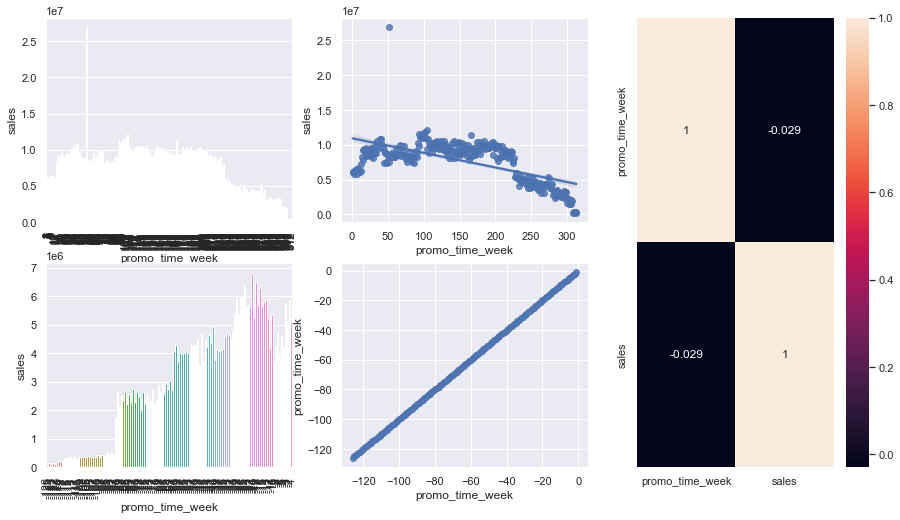

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec (2,3)


plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promocao extendida
sns.barplot(data =aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promocao regular
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='promo_time_week');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method ='pearson'), annot = True);




### H8.  Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** Lojas abertas durante o Nata  VENDEM MENOS

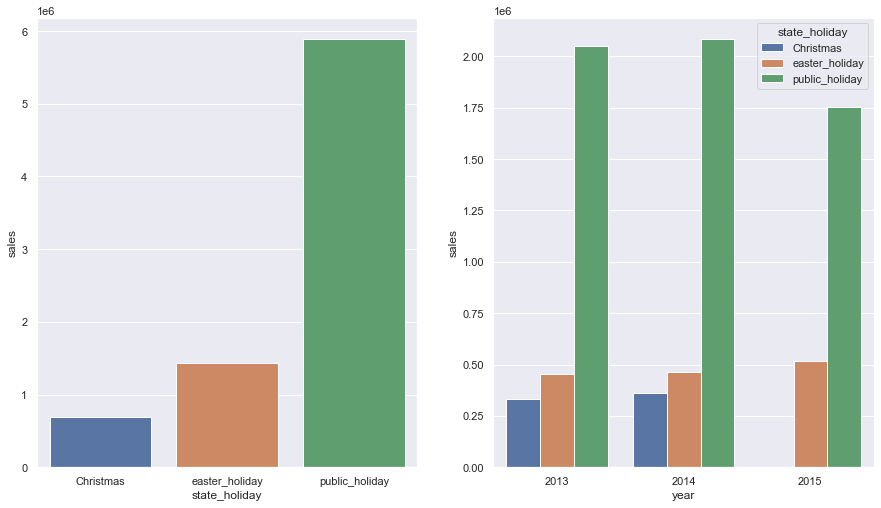

In [37]:
#filtrando as vendas que nao ocorreram em dias normais
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1= aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales');

#Verficando se ao longo dos anos houve alteracao de comportamento em relacao as vendas durante os feriados
plt.subplot(1,2,2)
aux2 = aux[['state_holiday', 'year','sales']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot (data=aux2, x='year',y='sales',hue='state_holiday');


In [38]:
### H9. Lojas deveriam vendar mais ao longo dos anos
**Falsa** Lojas VENDEM MENOS ao longo dos ANOS 

SyntaxError: invalid syntax (1074776276.py, line 2)

In [ ]:
#gerando gráfico de barras para verificar as vendas ao longo dos anos retirando o ano de 2015 pois ele nao está completo

aux= df4[df4['year']<2015]
plt.subplot(1,3,1)

aux1 = aux[['sales','year']].groupby('year').sum().reset_index()
sns.barplot(data=aux1, x='year',y='sales');


#vericando a tendendecia de vendas 
plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year',y='sales');

#verificando a forca da variavel ano no modelo
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot= True);



### H9. Lojas deveriam vendar mais no segundo semestre
**Falsa** Lojas VENDEM MENOS no SEGUNDO SEMESTRE 


In [ ]:
plt.subplot(1,3,1)
aux1 = df4[['sales','month']].groupby('month').sum().reset_index()
sns.barplot(data=aux1  , x='month', y='sales');


plt.subplot(1,3,2)
sns.regplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot= True);


### H11. Lojas deveriam vender mais depois do dia 10 de cada mes
**Falsa** Lojas VENDEM MAIS depois do DIA 10 de cada mes

In [ ]:
plt.subplot(2,2,1)
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()
sns.barplot(data=aux1, x= 'day', y='sales');

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True);

plt.subplot(2,2,4)
aux1['before_after'] =  aux1['day'].apply (lambda x : 'before_10_days' if  x<=10  else 'after_10_days')
aux2=aux1[['before_after','sales']].groupby('before_after').sum().reset_index();
sns.barplot(data= aux2, x='before_after', y='sales');


### **H12.** Lojas deveriam vender menos aos finais de semana.
**Falsa**:As lojas VENDEM MENOS aos FINS DE SEMANA.

In [ ]:
#df4['day_of_week'].drop_duplicates()

plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index();
sns.barplot(data = aux1, x='day_of_week', y ='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**Falsa**:As lojas VENDEM MENOS nos FERIADOS ESCOLARES, EXCETO JULHO E AGOSTO

In [ ]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(data=aux1,x='school_holiday', y ='sales');

plt.subplot(2,1,2)

aux2= df4[['school_holiday','sales','month']].groupby(['school_holiday','month']).sum().reset_index();

sns.barplot(data=aux2, x='month', y='sales',hue='school_holiday');




### 4.2.1 Resumo das hipóteses


In [ ]:
from tabulate import tabulate


In [ ]:
tab =[
      ['Hipoteses','Conclusao','Relevancia'],
      ['H1', 'Falsa','Baixa'],
      ['H2', 'Falsa','Media'],
      ['H3', 'Falsa','Media'],
      ['H4', 'Falsa','Baixa'],
      ['H5', '-','-'],
      ['H7', 'Falsa','Baixa'],
      ['H8', 'Falsa','Media'],
      ['H9', 'Falsa','Alta'],
      ['H10', 'Falsa','Alta'],   
      ['H11', 'Verdadeira','Alta'],
      ['H12', 'Falsa','Alta'],
      ['H13', 'Verdadeira','Baixa'],
      ]
print(tabulate(tab,headers='firstrow'))


## 4.3 Analise Multivariada

#### 4.3.1 Numerical Attributes

In [ ]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao,annot=True);

#### 4.3.2 Numerical Attributes

<AxesSubplot:>

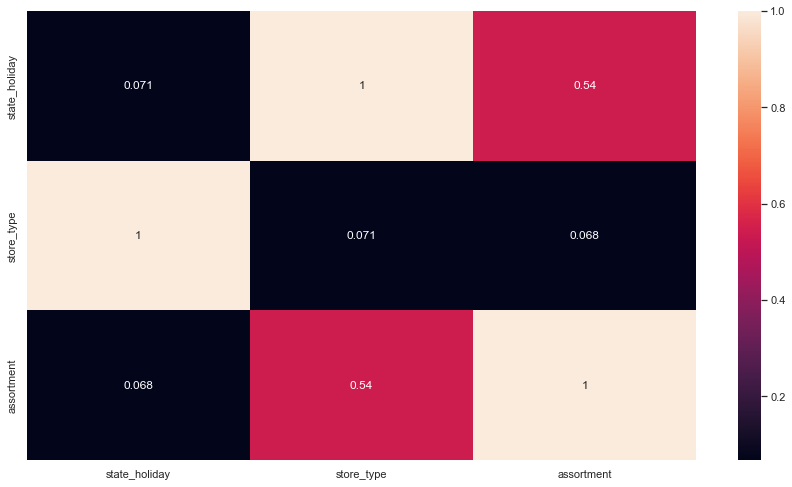

In [66]:
#Only categorical data
a= df4.select_dtypes(include='object')


a1 = cramer_v(a['state_holiday'],a['store_type'])
a2 = cramer_v(a['state_holiday'],a['state_holiday'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['store_type'])
a5 = cramer_v(a['store_type'],a['state_holiday'])

a6 = cramer_v(a['store_type'],a['assortment'])

a7  = cramer_v(a['assortment'],a['store_type'])
a8  = cramer_v(a['assortment'],a['state_holiday'])
a9  = cramer_v(a['assortment'],a['assortment'])


d= pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type'   :[a4,a5,a6],         
              'assortment'   :[a7,a8,a9] })

d= d.set_index(d.columns);

sns.heatmap(d,annot=True)




# 5.0 PASSO 05 - DATA PREPARATION


In [68]:
df5 = df4.copy()

## 5.1 Normalizacao

## 5.1 Rescaling

In [71]:
#Escollhendo as variáveis numéricas
a= df5.select_dtypes(include =['int64','float64'])

a.head()


,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

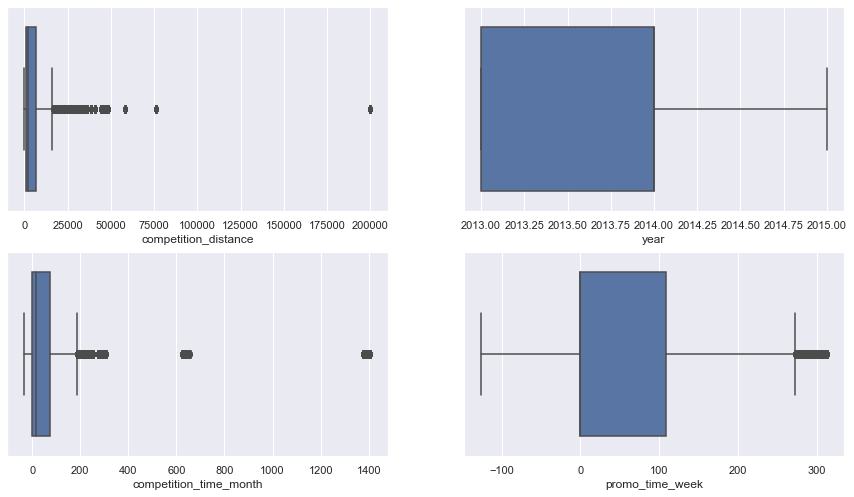

In [83]:
#Verificando se as variaveis tem outliers atraves do boxplot

plt.subplot (2,2,1)
sns.boxplot(df5['competition_distance']);

plt.subplot (2,2,2)

sns.boxplot(df5['year']); 

plt.subplot (2,2,3)
sns.boxplot(df5['competition_time_month']);

plt.subplot (2,2,4)          
sns.boxplot(df5['promo_time_week']);

C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

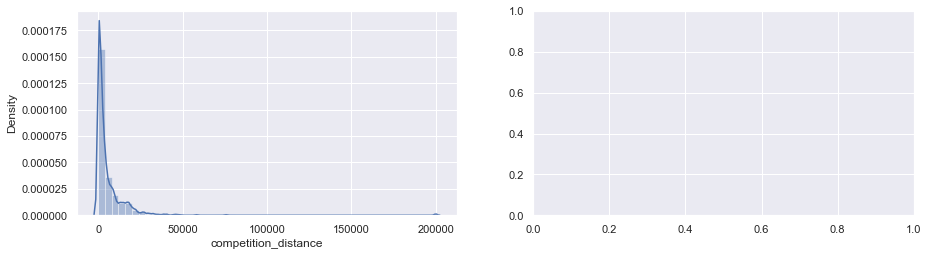

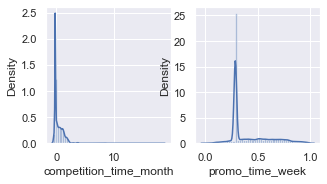

In [96]:
#Verificando a distribuicao antes do scaling
plt.subplot (2,2,1)
sns.distplot(df5['competition_distance']);

plt.subplot (2,2,2)
sns.displot(df5['year']); 

plt.subplot (2,2,3)
sns.distplot(df5['competition_time_month']);

plt.subplot (2,2,4)          
sns.distplot(df5['promo_time_week']);


### Métodos escolhidos para scaling
Iremos utilizar **min-max** nas variáveis **year**  e **promo_time_week** por nao terem outliers

Iremos utilizar **robust scaler** nas variáveis **competition_time_month** e **competition_distance** por terem outiliers



In [104]:
rs  = RobustScaler ()
mms = MinMaxScaler()
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
                                                                       
# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year 
df5['year'] = mms.fit_transform(df5[['year']].values)


C:\Users\Jacqueline\.conda\envs\DataSciente_Em_Producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


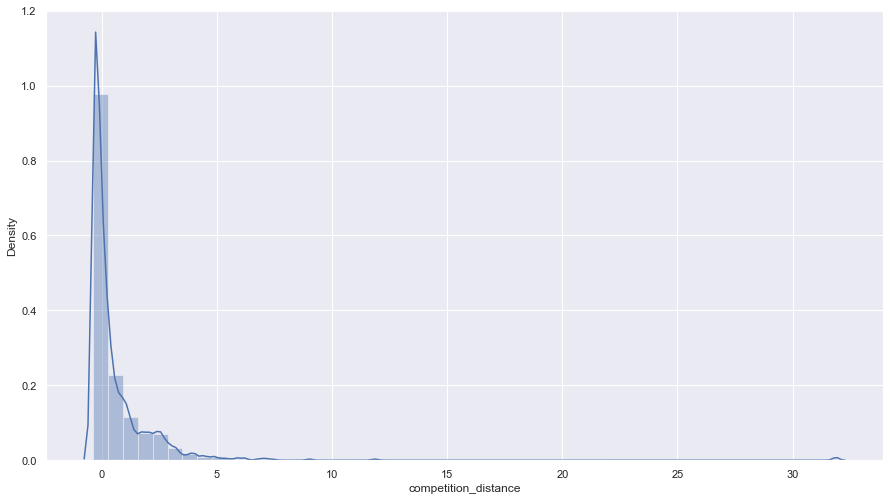

In [105]:
#Verificando a distribuicao após do scaling
#plt.subplot (2,2,1)
sns.distplot(df5['competition_distance']);

plt.subplot (2,2,2)
sns.distplot(df5['year']); 

plt.subplot (2,2,3)
sns.distplot(df5['competition_time_month']);

plt.subplot (2,2,4)          
sns.distplot(df5['promo_time_week']);


In [ ]:
###Natureza ciclica
# month 
# day 
#week of year
#day of week

In [ ]:
## 5.1 Transformação
